In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os, sys, fnmatch
import numpy as np
from lxml import etree
import hashlib, json
import re
import pandas as pd
import pickle
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [3]:
with open('./public_bouy_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
with open('./public_bouy_target.pkl', 'rb') as f:
    targets = pickle.load(f)

## Отобразим данные

In [54]:
# item = np.random.randint(len(data))
item=23

In [55]:
# start = np.random.randint(data[item].shape[0]-200)
start = 6090

In [56]:
data[item].head()

,dx,dy,dz,t,station
0,-0.447491,0.609415,1.05373,1.665209e+09,0606_4339
1,-0.062228,0.528534,1.28533,1.665209e+09,0606_4339
2,0.360255,0.337573,1.59773,1.665209e+09,0606_4339
3,0.730211,0.018035,1.70275,1.665209e+09,0606_4339
4,0.983110,-0.428559,1.69486,1.665209e+09,0606_4339


In [57]:
displacements = data[item][['dx','dy','dz']].values
displacements.shape

(6751, 3)

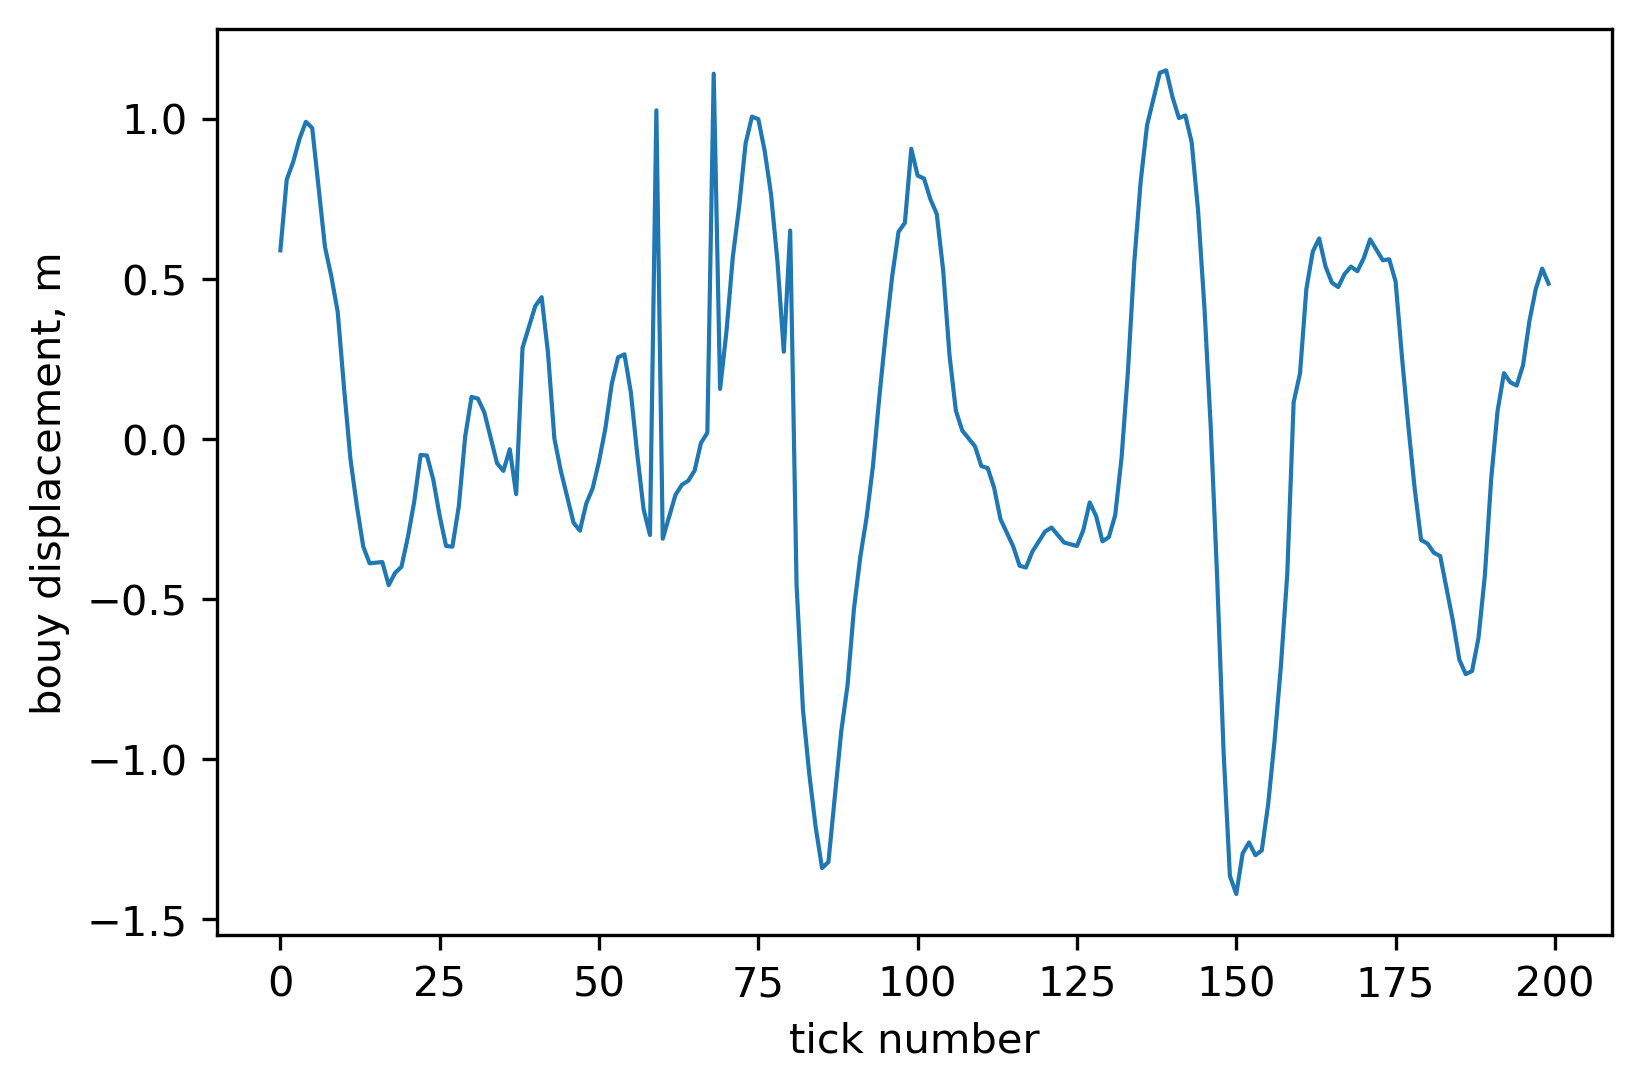

In [59]:
f = plt.figure(figsize=(6,4), dpi=300)
plt.plot(np.arange(200), displacements[start:start+200, 1], linewidth=1)
plt.xlabel('tick number')
plt.ylabel('bouy displacement, m');

## Решим задачу авторегрессии

и далее по величине ошибки авторегрессии определим, является ли очередное показание аномалией или нет

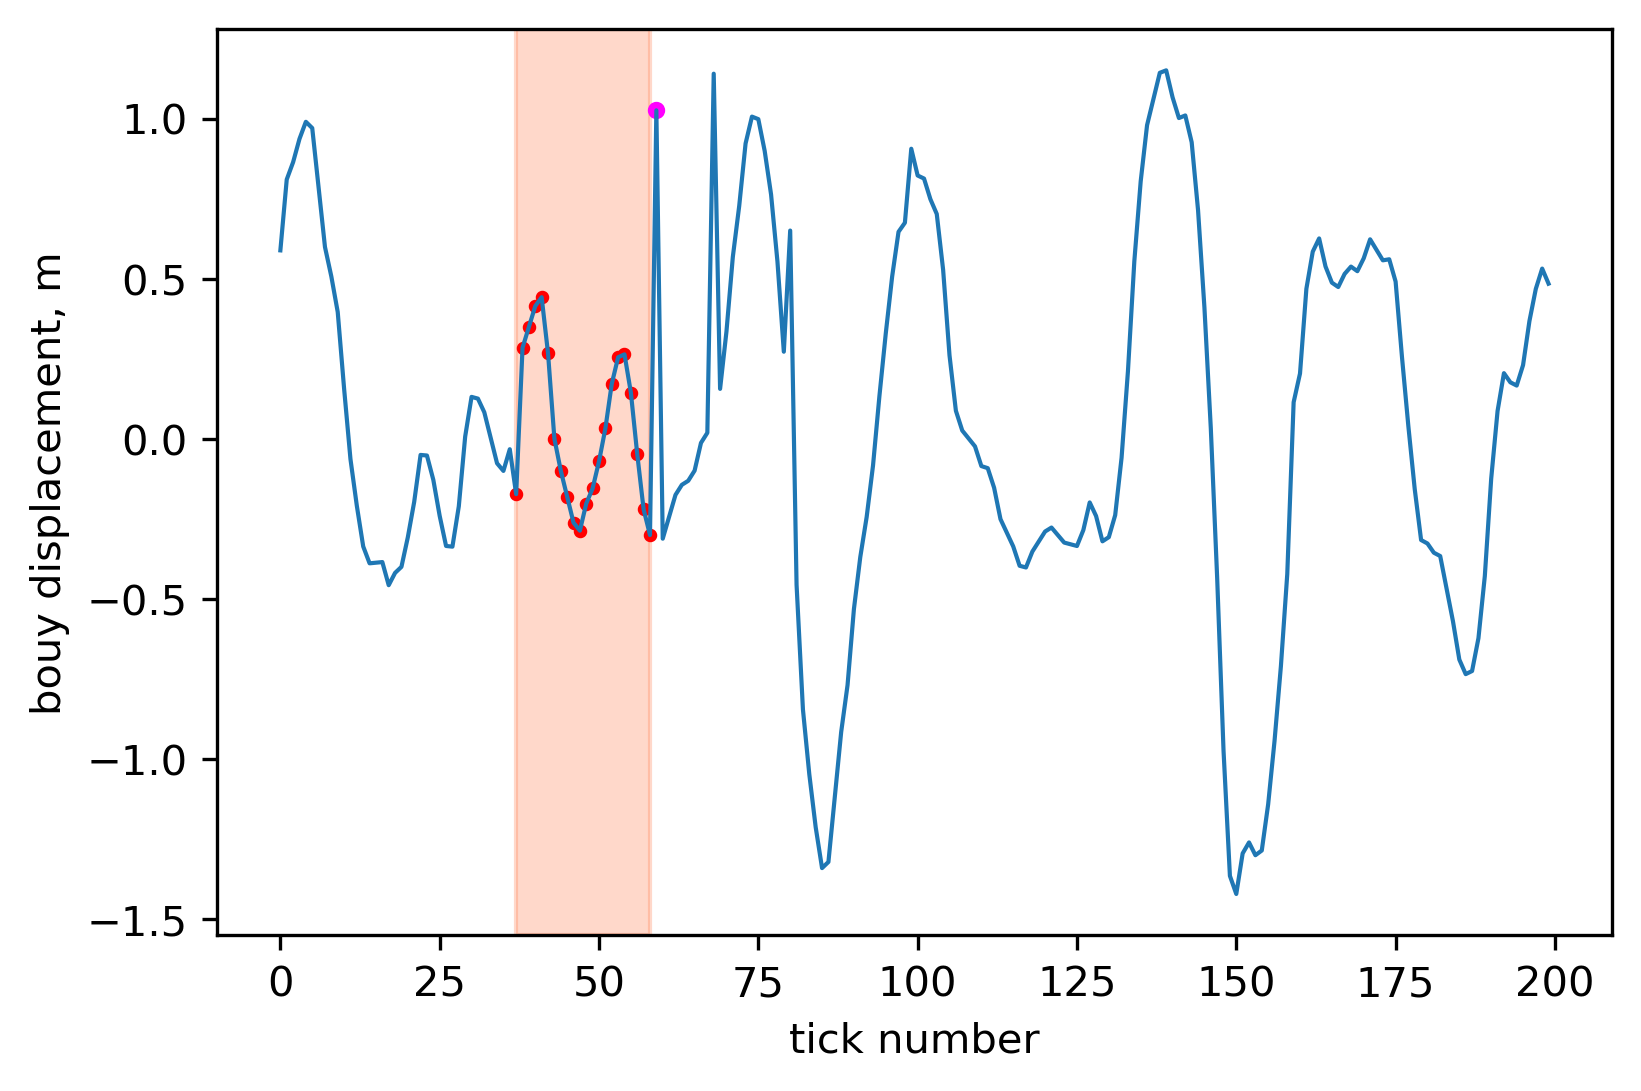

In [68]:
int_start = 37
window_width = 20
f = plt.figure(figsize=(6,4), dpi=300)
plt.plot(np.arange(200), displacements[start:start+200, 1], linewidth=1)
plt.gca().axvspan(int_start, int_start+window_width+1, alpha=0.3, color='coral')
plt.scatter(np.arange(int_start, int_start+window_width+2),
            displacements[start+int_start:start+int_start+window_width+2, 1], c='red', s=5)
plt.scatter(np.arange(int_start+window_width+2, int_start+window_width+3),
            displacements[start+int_start+window_width+2:start+int_start+window_width+3, 1], c='magenta', s=10)
plt.xlabel('tick number')
plt.ylabel('bouy displacement, m');

In [71]:
history_length = 30
forecast_range = 1

In [69]:
def get_ARproblem_table(df, history_length, forecast_range):
    X_AR = []
    Y_AR = []
    for start in range(df.shape[0]):
        if start < history_length-1:
            continue
        if start+forecast_range >= df.shape[0]:
            break
            
        x = df[['dx','dy','dz']].iloc[start+1-history_length:start+1]
        X_AR.append(x)
        
        y = df[['dx','dy','dz']].iloc[start+1:start+1+forecast_range]
        Y_AR.append(y)
    
    return X_AR, Y_AR

In [70]:
def vectorize_data(Xdata, Ydata):
    retX = []
    retY = []
    for x,y in zip(Xdata, Ydata):
        xprime = x.values.reshape((-1,1))
        yprime = y.values.reshape((-1,1))
        retX.append(xprime)
        retY.append(yprime)
    return retX, retY

In [ ]:
x_AR = []
y_AR = []
for d in tqdm_notebook(data):
    x, y = get_ARproblem_table(d, history_length, forecast_range)
    x_AR.append(x)
    y_AR.append(y)

In [6]:
with open('./x_AR_vectorized.pkl', 'rb') as f:
    x_AR_vectorized = pickle.load(f)

In [7]:
with open('./y_AR_vectorized.pkl', 'rb') as f:
    y_AR_vectorized = pickle.load(f)

In [8]:
with open('./x_AR_vectorized_concat.pkl', 'rb') as f:
    x_AR_vectorized_train = pickle.load(f)

In [9]:
with open('./y_AR_vectorized_concat.pkl', 'rb') as f:
    y_AR_vectorized_train = pickle.load(f)

In [10]:
x_AR_vectorized_train.shape

(233282, 90)

In [11]:
y_AR_vectorized_train.shape

(233282, 3)

In [12]:
m = Ridge()

In [13]:
m.fit(x_AR_vectorized_train, y_AR_vectorized_train)

Ridge()

In [14]:
yAR_approx = m.predict(x_AR_vectorized_train)

In [15]:
yAR_approx.shape

(233282, 3)

In [16]:
rse = np.square(yAR_approx-y_AR_vectorized_train).sum(axis=1)
rse.shape

(233282,)

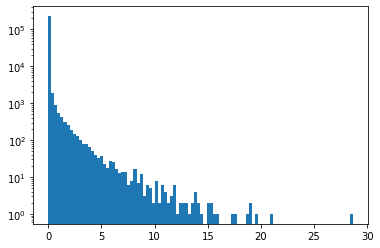

In [17]:
plt.hist(rse, bins=100)
plt.yscale('log')

In [18]:
p = 0.05

In [19]:
perc = np.percentile(rse, (1-p)*100)

In [20]:
perc

0.14115835557103612

In [21]:
pred_targets = []
for xAR,yAR,target in tqdm_notebook(zip(x_AR_vectorized, y_AR_vectorized, targets), total=len(x_AR_vectorized)):
    yAR_approx = m.predict(xAR)
    rse = np.square(yAR_approx-yAR).sum(axis=1)
    pred_target = np.zeros(rse.shape[0], dtype=bool)
    pred_target[np.where(rse>=perc)] = True
    pred_target = np.concatenate([np.zeros(history_length, dtype=bool), pred_target])
    pred_targets.append(pred_target)

/tmp/ipykernel_22930/2881040192.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xAR,yAR,target in tqdm_notebook(zip(x_AR_vectorized, y_AR_vectorized, targets), total=len(x_AR_vectorized)):


  0%|          | 0/40 [00:00<?, ?it/s]

In [22]:
pred_targets = np.concatenate(pred_targets)
pred_targets.shape

(234482,)

In [23]:
true_targets = np.concatenate(targets)
true_targets.shape

(234482,)

In [24]:
f1_score(true_targets, pred_targets)

0.3687473147977659

In [25]:
scores = []
for p in tqdm_notebook(np.linspace(0.001, 0.101, 101)):
    perc = np.percentile(rse, (1-p)*100)
    pred_targets = []
    for xAR,yAR,target in zip(x_AR_vectorized, y_AR_vectorized, targets):
        yAR_approx = m.predict(xAR)
        rse = np.square(yAR_approx-yAR).sum(axis=1)
        pred_target = np.zeros(rse.shape[0], dtype=bool)
        pred_target[np.where(rse>=perc)] = True
        pred_target = np.concatenate([np.zeros(history_length, dtype=bool), pred_target])
        pred_targets.append(pred_target)
    pred_targets = np.concatenate(pred_targets)
    true_targets = np.concatenate(targets)
    f1 = f1_score(true_targets, pred_targets)
    scores.append({'p': p, 'f1score': f1})

/tmp/ipykernel_22930/3748070729.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm_notebook(np.linspace(0.001, 0.101, 101)):


  0%|          | 0/101 [00:00<?, ?it/s]

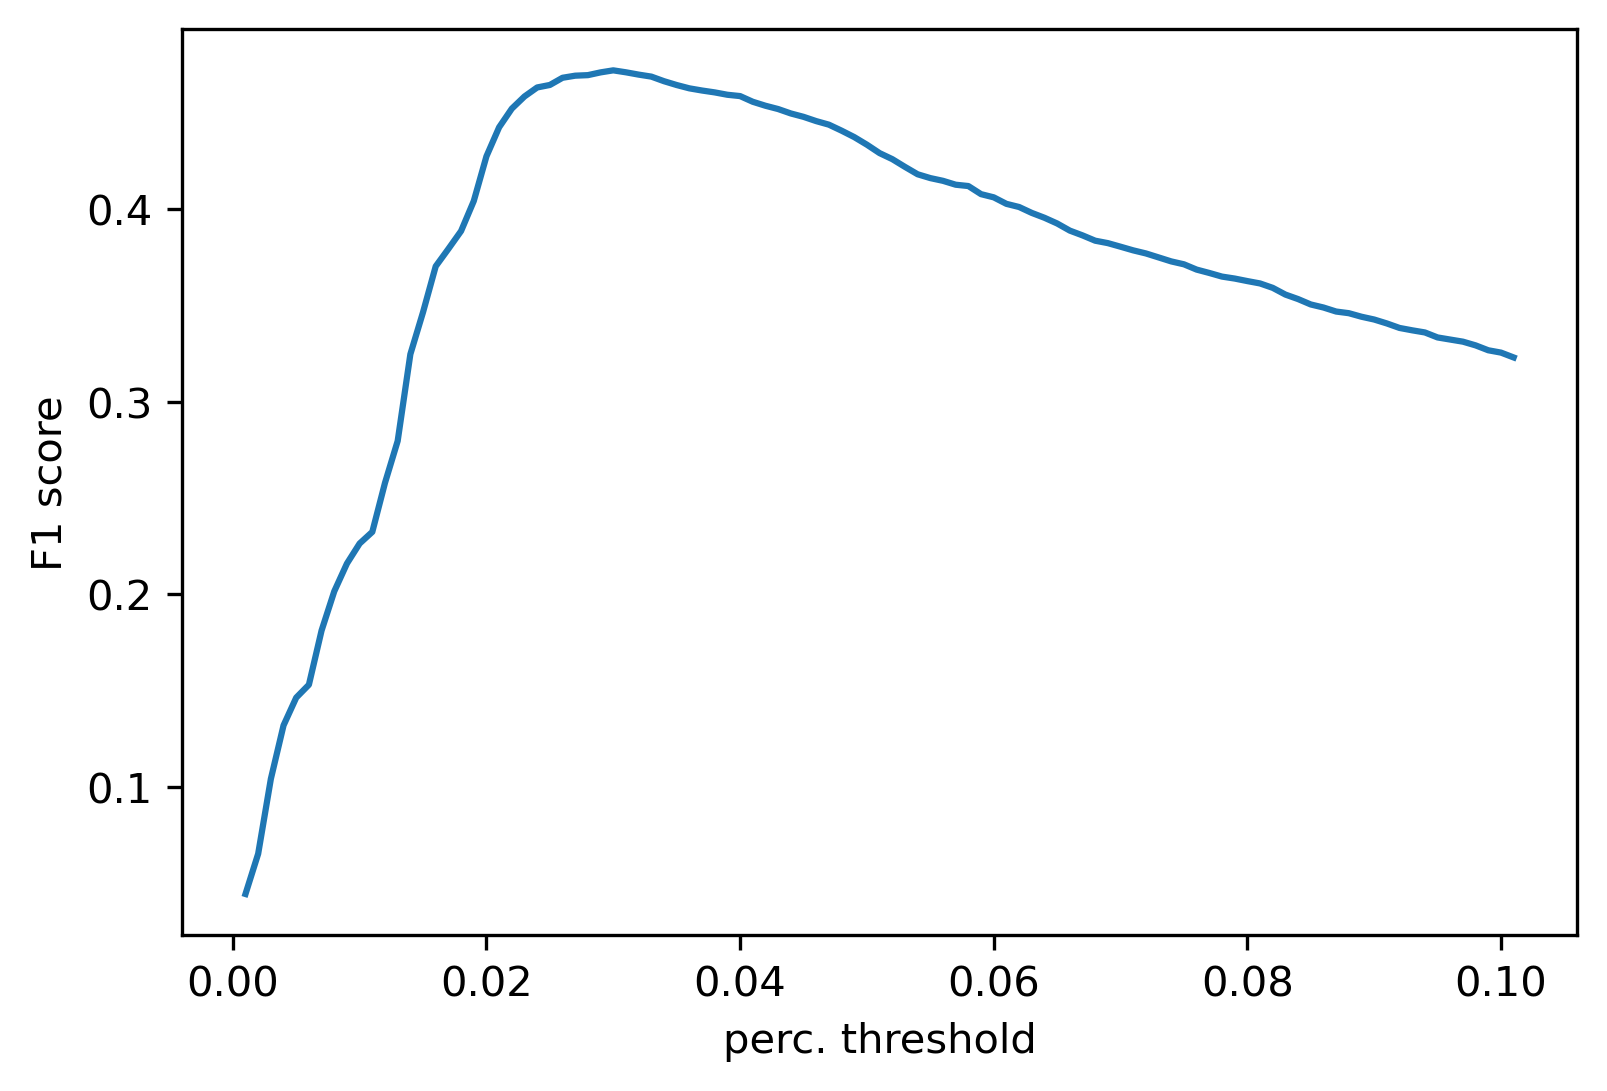

In [62]:
f = plt.figure(figsize=(6,4), dpi=300)
plt.plot([d['p'] for d in scores], [d['f1score'] for d in scores])
plt.xlabel('perc. threshold')
plt.ylabel('F1 score');

In [52]:
p_optim = [d['p'] for d in scores][np.argmax([d['f1score'] for d in scores])]
p_optim

0.030000000000000002

In [54]:
rse_threshold = np.percentile(rse, (1-p_optim)*100)
rse_threshold

0.26881897340784244

In [28]:
[d['f1score'] for d in scores][np.argmax([d['f1score'] for d in scores])]

0.4723026442771665

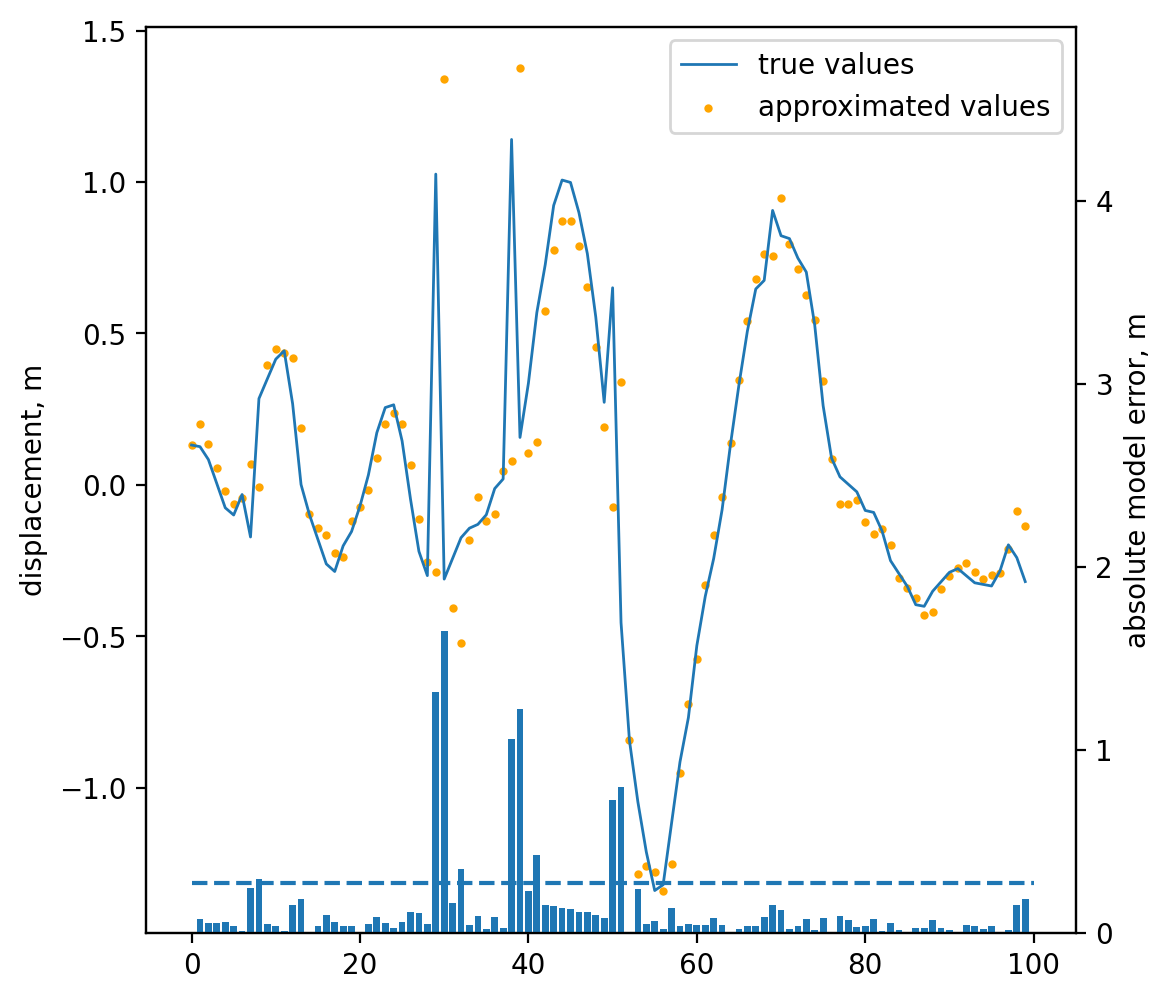

In [66]:
# item = np.random.randint(len(targets))
item=23
# start = np.random.randint(y_AR_vectorized[item].shape[0]-200)
start = 6090

f = plt.figure(figsize=(6,6), dpi=200)
plt.plot(np.arange(100),
         y_AR_vectorized[item][start:start+100, 1], linewidth=1, label='true values')
yAR_approx = m.predict(x_AR_vectorized[item])
plt.scatter(np.arange(100),
            yAR_approx[start:start+100, 1], s=4, c='orange',
            label='approximated values')
plt.ylabel('displacement, m')
plt.legend(fontsize=10, loc='upper right')

ax2 = plt.gca().twinx()
ax2.bar(np.arange(100), np.abs(yAR_approx[start:start+100, 1]-y_AR_vectorized[item][start:start+100, 1]))
ax2.set_ylim(0, np.abs(yAR_approx[start:start+100, 1]-y_AR_vectorized[item][start:start+100, 1]).max()*3)
ax2.set_ylabel('absolute model error, m')
ax2.hlines(rse_threshold, 0, 100, linestyles='dashed')

## Применим модель идентификации аномалий к тестовым данным

In [67]:
with open('./private_bouy_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [73]:
x_AR_test = []
y_AR_test = []
for d in tqdm_notebook(test_data):
    x, y = get_ARproblem_table(d, history_length, forecast_range)
    x_AR_test.append(x)
    y_AR_test.append(y)

/tmp/ipykernel_22930/2319135159.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(test_data):


  0%|          | 0/20 [00:00<?, ?it/s]

In [74]:
x_AR_vectorized_test = []
y_AR_vectorized_test = []
for x,y in tqdm_notebook(zip(x_AR_test, y_AR_test), total=len(x_AR_test)):
    xAR_test_vec, yAR_test_vec = vectorize_data(x, y)
    xAR_test_vec = np.concatenate(xAR_test_vec, axis=1).T
    yAR_test_vec = np.concatenate(yAR_test_vec, axis=1).T
    x_AR_vectorized_test.append(xAR_test_vec)
    y_AR_vectorized_test.append(yAR_test_vec)

/tmp/ipykernel_22930/2764986422.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x,y in tqdm_notebook(zip(x_AR_test, y_AR_test), total=len(x_AR_test)):


  0%|          | 0/20 [00:00<?, ?it/s]

In [77]:
with open('./x_AR_vectorized_test.pkl', 'rb') as f:
    x_AR_vectorized_test = pickle.load(f)

In [78]:
with open('./y_AR_vectorized_test.pkl', 'rb') as f:
    y_AR_vectorized_test = pickle.load(f)

In [83]:
with open('./x_AR_vectorized_test_concat.pkl', 'rb') as f:
    x_AR_vectorized_test_concat = pickle.load(f)

In [84]:
with open('./y_AR_vectorized_test_concat.pkl', 'rb') as f:
    y_AR_vectorized_test_concat = pickle.load(f)

In [85]:
x_AR_vectorized_test_concat.shape, y_AR_vectorized_test_concat.shape

((135830, 90), (135830, 3))

In [86]:
pred_targets_test = []
for xAR,yAR in tqdm_notebook(zip(x_AR_vectorized_test, y_AR_vectorized_test), total=len(x_AR_vectorized_test)):
    yAR_approx = m.predict(xAR)
    rse = np.square(yAR_approx-yAR).sum(axis=1)
    pred_target = np.zeros(rse.shape[0], dtype=bool)
    pred_target[np.where(rse >= rse_threshold)] = True
    pred_target = np.concatenate([np.zeros(history_length, dtype=bool), pred_target])
    pred_targets_test.append(pred_target)

/tmp/ipykernel_22930/4076270674.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xAR,yAR in tqdm_notebook(zip(x_AR_vectorized_test, y_AR_vectorized_test), total=len(x_AR_vectorized_test)):


  0%|          | 0/20 [00:00<?, ?it/s]

In [87]:
pred_targets_test = np.concatenate(pred_targets_test)
pred_targets_test.shape

(136430,)

In [88]:
with open('./pred_targets_test_AR_LR.pkl', 'wb') as f:
    pickle.dump(pred_targets_test, f)